In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from monai.transforms import Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom, Resize
import os
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from tqdm import tqdm
import cv2

In [2]:
device = torch.device("cuda:0")

In [3]:
class CTCOVIDDataset(Dataset):

    def __init__(self, transforms):
        self.IMG_SIZE = 224
        self.COVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Images-processed-new/CT_COVID'
        self.NonCOVID = 'C:/Users/rrsoo/AdvancedStuff/Medical_AI/Images-processed-new/CT_NonCOVID'
        self.LABELS = {self.NonCOVID:0, self.COVID:1}
        self.training_data = []
        
        for label in self.LABELS:
            for f in os.listdir(label):
                path = os.path.join(label, f)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                self.training_data.append([np.array(img), self.LABELS[label]])
                
        np.random.shuffle(self.training_data)
        
        self.X = torch.Tensor([i[0] for i in self.training_data]).view(-1, 3, 224, 224)
        self.X/=255
        self.y = torch.Tensor([i[1] for i in self.training_data])
        
        self.transforms = transforms

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
#Tune the transforms
train_transforms = transforms.Compose([
    LoadPNG(),
    AddChannel(),
    ScaleIntensity(),
    RandRotate(degrees=15, prob=0.5),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    Resize(spatial_size=(224, 224)),
    ToTensor()
])

In [5]:
train_ds = CTCOVIDDataset(train_transforms)
train_loader = DataLoader(train_ds, batch_size=20, shuffle=True)

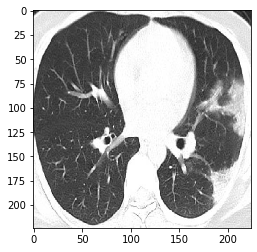

In [6]:
img = 0
for batch in train_loader:
    img = batch
plt.imshow(img[0][0].view(224, 224, 3))

In [7]:
def train(model, trainloader, optimizer, criterion, epochs, batch_size):
    model.train()
    for epoch in range(epochs):
        total = 0
        correct = 0
        train_loss = 0
        for data in tqdm(trainloader):
            X, y = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y.long())
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            for index, i in enumerate(output):
                if torch.argmax(i) == y[index]:
                    correct+=1
                total+=1
        print("Loss:", train_loss)
        print("Acc:", correct/total)

In [8]:
model = torchvision.models.vgg16(pretrained = True).to(device)
#model1 = torchvision.models.densenet121(pretrained = True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
for param in model.parameters():
    param.requires_grad = False

#Tune the number of hidden layers, hidden units, kernel_initializer, add batch norm
layers = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 512)),
    ('activation1', nn.ReLU()),
    ('dropout1', nn.Dropout()),
    ('fc2', nn.Linear(512, 256)),
    ('activation2', nn.ReLU()),
    ('dropout2', nn.Dropout()),
    ('fc3', nn.Linear(256, 128)),
    ('activation3', nn.ReLU()),
    ('dropout3', nn.Dropout()),
    ('fc4', nn.Linear(128, 2)),
    ('out', nn.Sigmoid())
    
])).to(device)

model.classifier = layers

optimizer = optim.Adam(model.parameters()) #Tune the learning rate
criterion = nn.CrossEntropyLoss()

train(model, train_loader, optimizer, criterion, 10, 10) #Tune batch size

  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 26.549449563026428
Acc: 0.5141318977119784


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 26.50361728668213
Acc: 0.5356662180349933


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 26.186295449733734
Acc: 0.5423956931359354


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 25.879235804080963
Acc: 0.566621803499327


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 24.79371303319931
Acc: 0.6083445491251682


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 22.76001861691475
Acc: 0.7133243606998654


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 22.095220029354095
Acc: 0.7173620457604307


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 21.87581717967987
Acc: 0.7348586810228802


  0%|          | 0/38 [00:00<?, ?it/s]

Loss: 20.080553472042084
Acc: 0.775235531628533


100%|██████████| 38/38 [00:10<00:00,  3.59it/s]

Loss: 19.118102222681046
Acc: 0.8048452220726783
